In [1]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  26.7M      0 --:--:--  0:00:12 --:--:-- 39.3M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [4]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locally, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


In [5]:
from sklearn.model_selection import train_test_split
X_learn, X_test, label_learn, label_test = train_test_split(jetImage, target, test_size=0.33)
print(X_learn.shape, X_test.shape)

X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.33)
print(X_train.shape,X_val.shape)

del jetImage, target

(33500, 100, 100) (16500, 100, 100)
(22445, 100, 100) (11055, 100, 100)


In [6]:
X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0],1, X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1], X_test.shape[2]))

print(X_train.shape, X_val.shape, X_test.shape)

(22445, 1, 100, 100) (11055, 1, 100, 100) (16500, 1, 100, 100)


In [7]:
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
from h5py._hl.group import numpy
X_train =  torch.from_numpy(X_train)
X_test =  torch.from_numpy(X_test)
X_val =  torch.from_numpy(X_val)



In [9]:
label_test = torch.tensor(label_test)
label_val = torch.tensor(label_val)
label_train = torch.tensor(label_train)



In [10]:
X_train = X_train.to(torch.float32)
X_test = X_test.to(torch.float32)
X_val = X_val.to(torch.float32)

In [28]:
X_val.dtype

torch.float32

In [11]:
print(X_train.shape, X_test.shape, X_val.shape)

torch.Size([22445, 1, 100, 100]) torch.Size([16500, 1, 100, 100]) torch.Size([11055, 1, 100, 100])


In [11]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size,shuffle=True)


In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.linear1 = nn.Linear(13*13*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(sigma.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [25]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 32 * 13 * 13),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 13, 13))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


In [26]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [27]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)



VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=5408, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=5408, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 13, 13))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32,

In [28]:
from torchsummary import summary

summary(vae, input_size=(1,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 50, 50]              80
            Conv2d-2           [-1, 16, 25, 25]           1,168
       BatchNorm2d-3           [-1, 16, 25, 25]              32
            Conv2d-4           [-1, 32, 13, 13]           4,640
           Flatten-5                 [-1, 5408]               0
            Linear-6                  [-1, 128]         692,352
            Linear-7                    [-1, 4]             516
            Linear-8                    [-1, 4]             516
           Encoder-9                    [-1, 4]               0
           Linear-10                  [-1, 128]             640
             ReLU-11                  [-1, 128]               0
           Linear-12                 [-1, 5408]         697,632
             ReLU-13                 [-1, 5408]               0
        Unflatten-14           [-1, 32,

In [29]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [30]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [31]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(1,1))
    targets = X_test.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = X_test[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [32]:
num_epochs = 50
loss_values = []
val_loss_values = []
for epoch in range(num_epochs):
  train_loss = train_epoch(vae,device,train_loader,optim)
  val_loss = test_epoch(vae,device,val_loader)
  loss_values.append(train_loss)
  val_loss_values.append(val_loss)
  print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  #plot_ae_outputs(vae.encoder,vae.decoder,n=10)



 EPOCH 1/50 	 train loss 253750.953 	 val loss 207062.762

 EPOCH 2/50 	 train loss 170288.396 	 val loss 135756.125

 EPOCH 3/50 	 train loss 117359.508 	 val loss 100599.085

 EPOCH 4/50 	 train loss 88346.452 	 val loss 77316.874

 EPOCH 5/50 	 train loss 71448.432 	 val loss 66095.271

 EPOCH 6/50 	 train loss 62450.492 	 val loss 60923.049

 EPOCH 7/50 	 train loss 57596.591 	 val loss 55592.798

 EPOCH 8/50 	 train loss 54365.892 	 val loss 54034.423

 EPOCH 9/50 	 train loss 52384.133 	 val loss 54712.158

 EPOCH 10/50 	 train loss 50831.334 	 val loss 51386.946

 EPOCH 11/50 	 train loss 49516.786 	 val loss 49401.508

 EPOCH 12/50 	 train loss 48324.846 	 val loss 49255.783

 EPOCH 13/50 	 train loss 47381.606 	 val loss 47937.581

 EPOCH 14/50 	 train loss 46383.039 	 val loss 47421.064

 EPOCH 15/50 	 train loss 45612.482 	 val loss 47346.148

 EPOCH 16/50 	 train loss 44855.565 	 val loss 46845.324

 EPOCH 17/50 	 train loss 44161.028 	 val loss 47600.066

 EPOCH 18/50 	 t

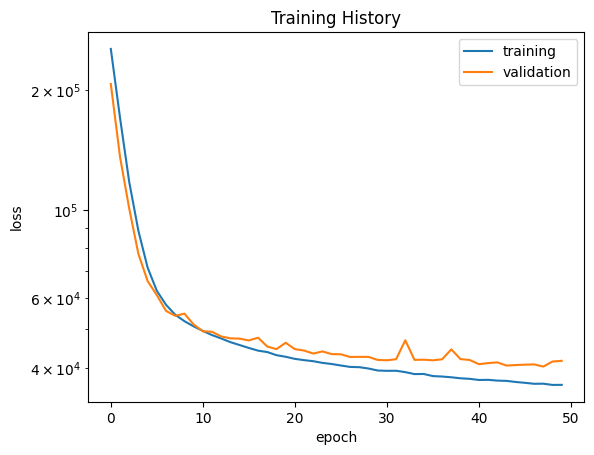

In [33]:
# plot training history
plt.plot(loss_values)
plt.plot(val_loss_values)
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()